### on/off, increment, 가우시안 노이즈 추가

In [77]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

# 시드 설정 - 동일한 시뮬레이션 결과를 위해 설정
# 1000_data: seed = 10
# 2000_data: seed = 20
# 10000_data: seed = 100 
np.random.seed(100)

# Set some general settings, to be used across all simulations
num_signals = 1000
fs = 24414 #sampling 주파수
n_seconds = 0.5 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

fpath = "C:/Users/stell/OneDrive/바탕 화면/10000_data/"
#fpath = 'C:/Users/User/Desktop/SCH/10000_data/'
Clean = np.load(fpath + 'clean_data.npy')
Clean = Clean[:1000]

In [78]:
# Generate artifact
frequency = 24414 / 10
period = 1 / frequency
num_waveforms = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

asymmetric_artifact = np.zeros((0, len(times)))  # (0, 4000)
artifact = np.zeros((num_signals, len(times)))  # (0, 4000)

Artifact = np.zeros((0, len(times)))  # (0, 4000)

print(num_waveforms)
print(samples_per_period)

1221
11


In [79]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    asymmetric_artifact = np.append(asymmetric_artifact, [osc_shape], axis=0)

print("Clean shape:", Clean.shape)  # (100, 4000)

# 음의 값이 2배가 되도록 y축 shifting
asymmetric_artifact = asymmetric_artifact * (-1.75) - 0.5

start = int(0.1 * fs)
mid = int(0.4 * fs)
end = int(0.5 * fs)

# Increment
for i in range(num_signals):
    # 각 구간의 크기를 맞추기 위해 전체 배열을 초기화
    increment_artifact = np.zeros((int(n_seconds * fs)))
    
    # 구간별로 배열을 채움
    increment_artifact[:start] = asymmetric_artifact[i, :start] * 0
    increment_artifact[start:mid] = asymmetric_artifact[i, start:mid] 
    increment_artifact[mid:end] = asymmetric_artifact[i, mid:end] * 0
    
    Artifact = np.append(Artifact, [increment_artifact], axis=0)
    
print("Artifact shape:", Artifact.shape)  # (N, 4000)

Clean shape: (1000, 4000)
Artifact shape: (1000, 12207)


In [80]:
mean = 0
std = 0.3
gaussian_noise = np.random.normal(mean, std, Artifact.shape)

Artifact_noisy = Artifact + gaussian_noise

print(Artifact[0, 400:405])
print(gaussian_noise[0, 400:405])
print(Artifact_noisy[0, 400:405])
print(Artifact_noisy.shape)

[-0. -0. -0. -0. -0.]
[-0.05933919 -0.25640184  0.00707925 -0.05113694 -0.32089988]
[-0.05933919 -0.25640184  0.00707925 -0.05113694 -0.32089988]
(1000, 12207)


data_signal shape: (1000, 4000)
signal_with_artifact shape: (1000, 12207)


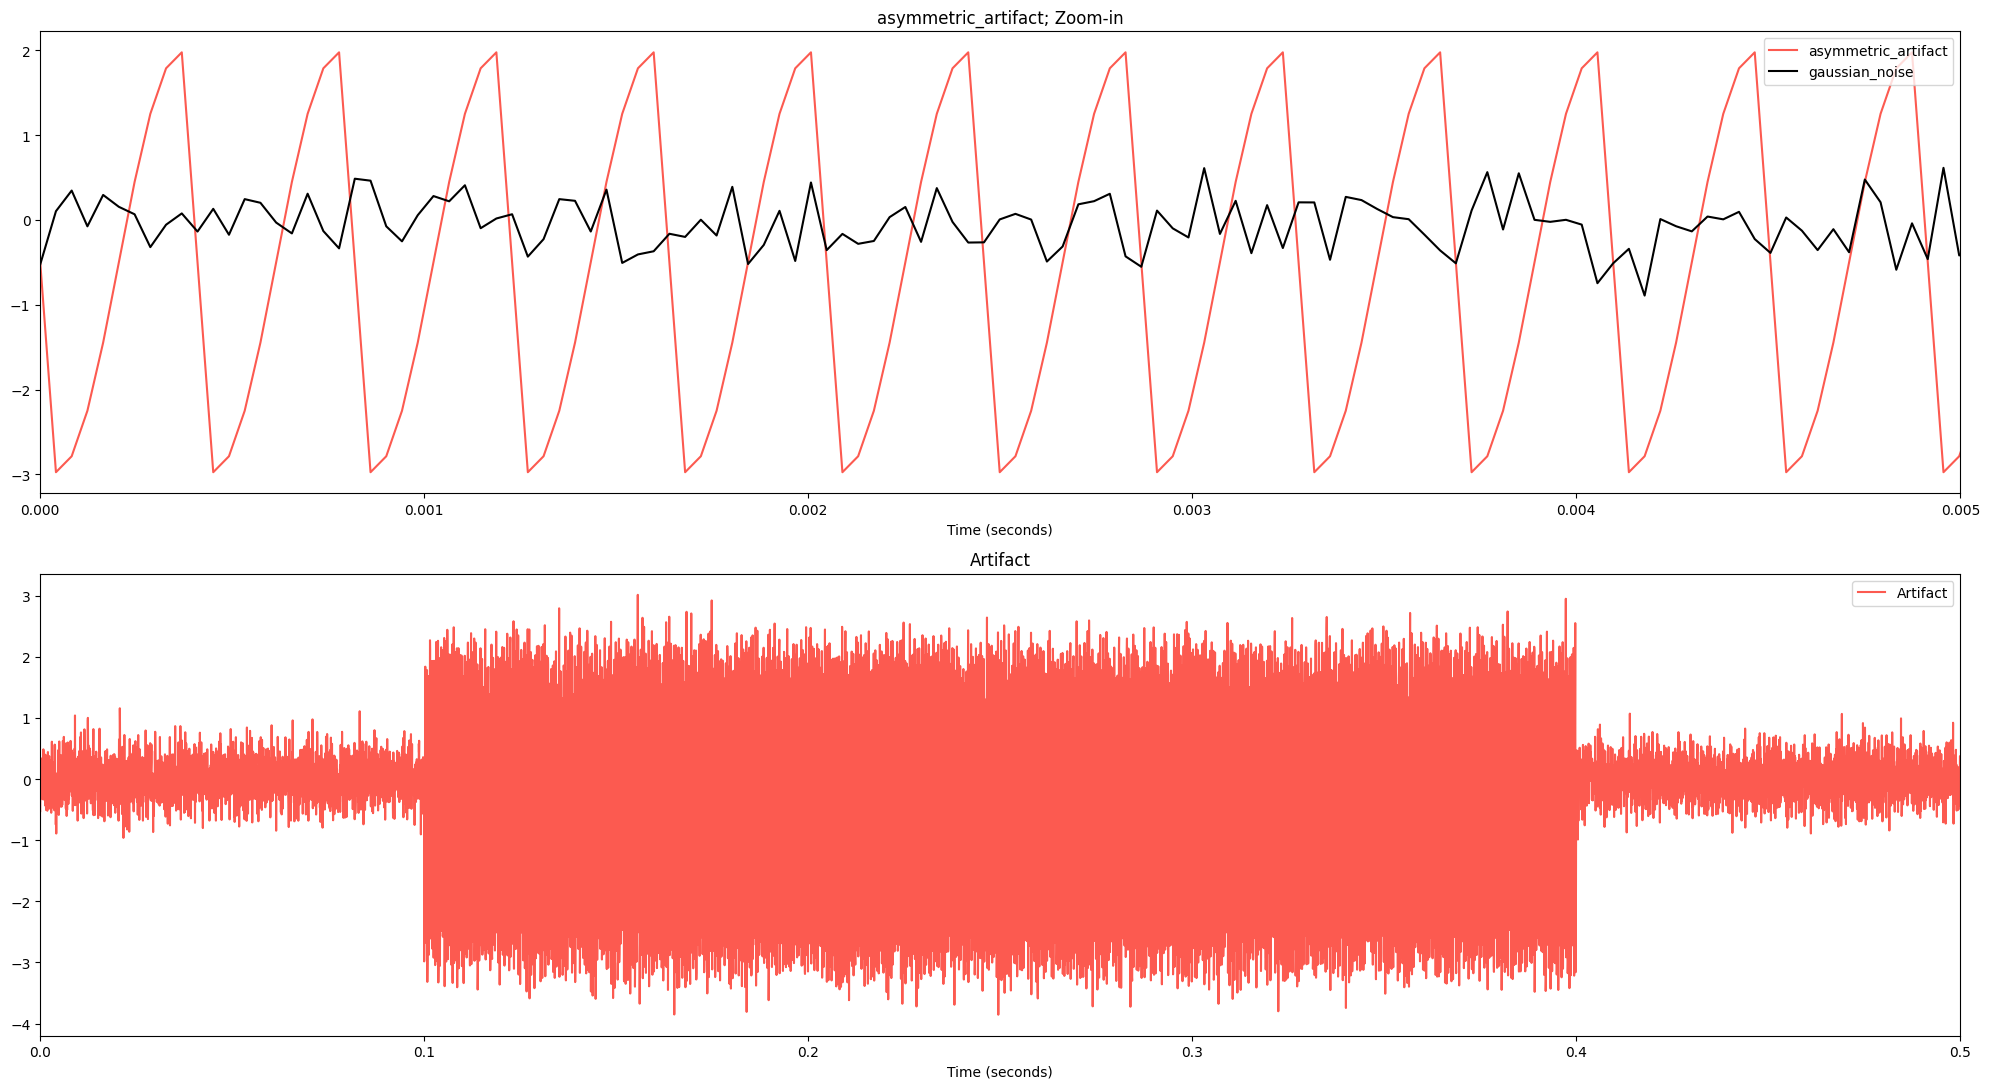

In [81]:
plt.figure(figsize=(20, 11))

num_sample = 0

plt.subplot(2, 1, 1)
plt.plot(times, asymmetric_artifact[num_sample, :], c='xkcd:coral', label = 'asymmetric_artifact')
plt.plot(times, gaussian_noise[num_sample, :], c='k', label = 'gaussian_noise')
plt.xlim([0, 0.005])
plt.legend()
# plt.gca().set_ylim([-5, 2])
plt.xlabel("Time (seconds)"); plt.title('asymmetric_artifact; Zoom-in')

plt.subplot(2, 1, 2)
plt.plot(times, Artifact_noisy[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Artifact')
plt.xlim([0, 0.5])


plt.tight_layout()

print('data_signal shape:', Clean.shape)
print('signal_with_artifact shape:', Artifact.shape)


In [85]:
# ------------------------------------< on-off set pattern 생성 >------------------------------------------------------------------------------------------
on_range = 10/24414
off_range = 178/24414
p_range = on_range + off_range
print(on_range, off_range, p_range)

data_pattern_regular = np.zeros((num_sample, int(n_seconds * fs)))

###### On-Off set version1; regular pattern #####
for idx in range(num_signals):
   pattern = np.zeros((int(n_seconds * fs)))
   for i in range(int(0.1 * fs), int(0.4 * fs), p_range*2):
      pattern[i:i+on_range] = 1

   pattern = pattern.astype(int)
   data_pattern_regular = np.append(data_pattern_regular, pattern)

Artifact_noisy = Artifact_noisy * data_pattern_regular

plt.figure(figsize=(20, 5))
num_sample = 0

plt.plot(times, Artifact_noisy[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Artifact')
plt.xlim([0, 0.5])

plt.tight_layout()

0 0 0


ValueError: range() arg 3 must not be zero

(0.0, 2.0)

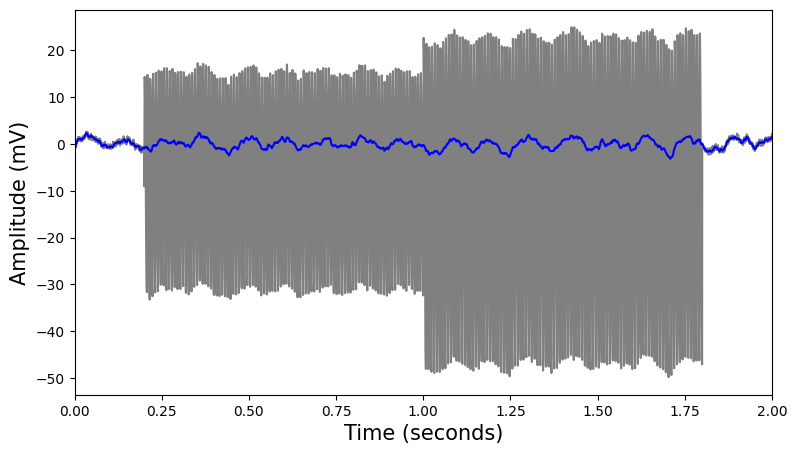

In [ ]:
# import sys
# sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
# from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot

# plt.figure(figsize=(9, 5))
# plt.plot(times, Contaminated[num_sample, :], c='gray', label = 'Artifact')
# plt.plot(times, Clean[num_sample, :], c='blue', label = 'Clean')
# plt.xlabel("Time (seconds)", fontsize=15)
# plt.ylabel("Amplitude (mV)", fontsize=15)
# plt.xlim([0, 2])


In [ ]:
# -------- < 저장 > ------------------------------------------------
# -------- < data > ------------------------------------------------

# np.save(fpath + "increment_artifact_data" + ".npy", Artifact_noisy)
